Download the data

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2023-03-17 05:49:48--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.85.7, 13.249.85.22, 13.249.85.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.85.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2023-03-17 05:49:48 (37.1 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.

In [ ]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Chinese.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Russian.txt', 'data/names/Polish.txt', 'data/names/Japanese.txt', 'data/names/Portuguese.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [ ]:
print(category_lines['Italian'][:5])

['Altoviti', 'Manco', 'Bandini', 'Nicolosi', 'Murtas']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





### Linear hidden unit based RNN class:

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)      

### GRU hidden unit based RNN class:

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUNet, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.GRU(input_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        
        combined = torch.cat((input, hidden), 1)
        a, hidden = self.i2h(input, hidden)  
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

gru = GRUNet(n_letters, n_hidden, n_categories)  
  

### LSTM hidden unit based RNN class:

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMNet, self).__init__()

        self.hidden_size = hidden_size
                
        self.i2h = nn.LSTM(input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size) 
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, input, hidden):
        
        out, hidden = self.i2h(input.view(1,1,-1),hidden) 
        output = self.i2o(hidden[0])
        output = self.softmax(output)      
        
        return output.view(1,-1), hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size),torch.zeros(1, 1, self.hidden_size))

lstm = LSTMNet(n_letters, n_hidden, n_categories)  

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [ ]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8691, -2.9368, -3.0153, -2.8562, -2.8045, -2.8788, -2.9031, -2.9880,
         -2.8619, -2.8595, -2.8207, -2.8750, -2.8317, -3.0337, -2.8968, -3.0070,
         -2.8429, -2.7914]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 17)


We will also want a quick way to get a training example (a name and its
language):




In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Arvanitoyannis
category = Dutch / line = Kann
category = Arabic / line = Wasem
category = Polish / line = Skala
category = Scottish / line = Dickson
category = Italian / line = Quattrocchi
category = Scottish / line = Wright
category = Irish / line = Sioda
category = Vietnamese / line = Vo
category = Vietnamese / line = Chu


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [ ]:
optimizer_rnn = torch.optim.Adam(rnn.parameters())
optimizer_gru = torch.optim.Adam(gru.parameters())
optimizer_lstm = torch.optim.Adam(lstm.parameters())

def train(category_tensor, line_tensor,model,optimizer):
    hidden = model.initHidden()

    # reset gradient
    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [ ]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor,model):
    hidden = model.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    return output

def eval_dataset(dataset,model):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate(line_tensor,model)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion

def experiment(model, optimizer):
  
  # Keep track of losses for plotting
  train_loss = 0
  all_train_losses = []
  all_validation_losses = []

  print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
  start = time.time()

  for iter in range(1, n_iters + 1):
      category, line, category_tensor, line_tensor = randomTrainingExample()
      output, loss = train(category_tensor, line_tensor, model, optimizer)
      train_loss += loss

      # Print iter number, train loss average, name and guess
      if iter % print_every == 0:
          guess, guess_i = categoryFromOutput(output)
          correct = '✓' if guess == category else '✗ (%s)' % category
          print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

      # Add current train loss average to list of losses
      if iter % plot_every == 0:
          all_train_losses.append(train_loss / plot_every)
          train_loss = 0
          
      # Compute loss based on validation data
      if iter % plot_every == 0:
          average_validation_loss, _ = eval_dataset(validation_data, model)

          # save model with best validation loss
          if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            if model == rnn:
              torch.save(model, 'char_rnn_classification_model.pt')
            elif model == gru:
              torch.save(model, 'char_gru_classification_model.pt')
            elif model == lstm:
              torch.save(model, 'char_lstm_classification_model.pt')                                          
          all_validation_losses.append(average_validation_loss)
  return all_train_losses, all_validation_losses


In [ ]:
print('RNN experiment')
all_train_losses_RNN, all_validation_losses_RNN = experiment(rnn, optimizer_rnn)

RNN experiment

Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 20s) 	1.9029 		Porras / Greek ✗ (Spanish)
10000 	12% 	(0m 35s) 	1.6727 		Marchetti / Italian ✓
15000 	18% 	(0m 49s) 	1.4364 		Miazga / Polish ✓
20000 	25% 	(1m 4s) 	1.4283 		Micheli / Italian ✓
25000 	31% 	(1m 19s) 	1.3668 		Hertz / German ✓
30000 	37% 	(1m 33s) 	1.3965 		Vykruta / Japanese ✗ (Czech)
35000 	43% 	(1m 48s) 	1.2833 		Krivolavy / Czech ✓
40000 	50% 	(2m 2s) 	1.2177 		Stramba / Czech ✓
45000 	56% 	(2m 16s) 	1.2105 		Ebden / Dutch ✗ (English)
50000 	62% 	(2m 30s) 	1.2137 		Azarola / Spanish ✓
55000 	68% 	(2m 45s) 	1.1715 		De leon / Korean ✗ (Spanish)
60000 	75% 	(2m 59s) 	1.2101 		Salcedo / Portuguese ✗ (Spanish)
65000 	81% 	(3m 13s) 	1.2168 		Gosselin / English ✗ (French)
70000 	87% 	(3m 28s) 	1.1485 		Hladky / Russian ✗ (Czech)
75000 	93% 	(3m 42s) 	1.0971 		Leek / Dutch ✗ (English)
80000 	100% 	(3m 57s) 	1.1286 		Rossem / Dutch ✓


In [ ]:
print('GRU experiment')
all_train_losses_GRU, all_validation_losses_GRU = experiment(gru, optimizer_gru)

GRU experiment

Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 36s) 	1.6488 		Romao / Polish ✗ (Portuguese)
10000 	12% 	(1m 16s) 	1.3230 		Toselli / Italian ✓
15000 	18% 	(1m 57s) 	1.0263 		Sniegowski / Polish ✓
20000 	25% 	(2m 37s) 	0.8121 		Chevalier / French ✓
25000 	31% 	(3m 17s) 	0.7082 		Pierre / French ✓
30000 	37% 	(3m 58s) 	0.6147 		Chung / Korean ✓
35000 	43% 	(4m 38s) 	0.5133 		Vann / Dutch ✗ (German)
40000 	50% 	(5m 19s) 	0.4693 		Milne / Scottish ✓
45000 	56% 	(5m 59s) 	0.3944 		Stevenson / Scottish ✓
50000 	62% 	(6m 43s) 	0.4123 		Fifield / French ✗ (English)
55000 	68% 	(7m 26s) 	0.3757 		Antonakos / Greek ✓
60000 	75% 	(8m 8s) 	0.3402 		Lambert / French ✓
65000 	81% 	(8m 51s) 	0.3116 		Gomulka / Polish ✓
70000 	87% 	(9m 33s) 	0.3339 		Szewc / Polish ✓
75000 	93% 	(10m 15s) 	0.3042 		Chung / Korean ✓
80000 	100% 	(10m 58s) 	0.2899 		Maslanka / Polish ✓


In [ ]:
print('LSTM experiment')
all_train_losses_LSTM, all_validation_losses_LSTM = experiment(lstm, optimizer_lstm)

LSTM experiment

Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 38s) 	1.6412 		Bautista / Italian ✗ (Spanish)
10000 	12% 	(1m 22s) 	1.2017 		Rovensky / Czech ✗ (Russian)
15000 	18% 	(2m 5s) 	0.9648 		Gravari / Italian ✗ (Greek)
20000 	25% 	(2m 48s) 	0.7695 		Antoun / Arabic ✓
25000 	31% 	(3m 31s) 	0.7065 		Akaike / Japanese ✓
30000 	37% 	(4m 15s) 	0.5799 		San nicolas / Spanish ✓
35000 	43% 	(4m 58s) 	0.4822 		Plamondon / French ✓
40000 	50% 	(5m 41s) 	0.4555 		Pyriev / Russian ✓
45000 	56% 	(6m 24s) 	0.4214 		Robertson / Scottish ✓
50000 	62% 	(7m 8s) 	0.3134 		Bui / Chinese ✓
55000 	68% 	(7m 51s) 	0.3204 		Nazari / Arabic ✓
60000 	75% 	(8m 35s) 	0.3115 		Tieu / Vietnamese ✓
65000 	81% 	(9m 19s) 	0.3434 		Doan / Vietnamese ✓
70000 	87% 	(10m 4s) 	0.3033 		Groe / German ✓
75000 	93% 	(10m 47s) 	0.2968 		Cheng / Chinese ✓
80000 	100% 	(11m 31s) 	0.2360 		St pierre / French ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




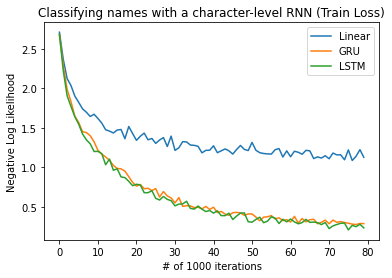

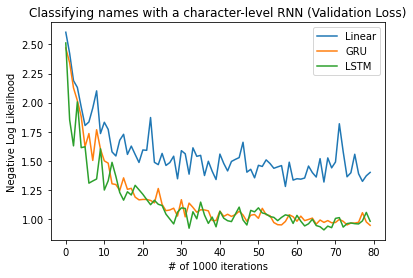

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses_RNN)
plt.plot(all_train_losses_GRU)
plt.plot(all_train_losses_LSTM)
plt.title('Classifying names with a character-level RNN (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear','GRU','LSTM'], loc='upper right')


plt.figure()
plt.plot(all_validation_losses_RNN)
plt.plot(all_validation_losses_GRU)
plt.plot(all_validation_losses_LSTM)
plt.title('Classifying names with a character-level RNN (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear','GRU','LSTM'], loc='upper right')


Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




### Linear Hidden Unit

Average test loss: 1.3025723196434522


<ipython-input-20-418b60ecb002>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-20-418b60ecb002>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


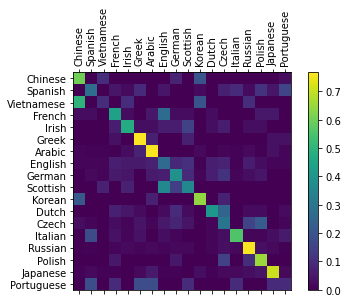

In [ ]:
# evaluate on test set and display confusion matrix
rnn = torch.load('char_rnn_classification_model.pt')
average_test_loss, confusion = eval_dataset(test_data, rnn)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




### GRU Hidden Unit

Average test loss: 0.9019137175628957


<ipython-input-21-15e0c1d649e1>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-21-15e0c1d649e1>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


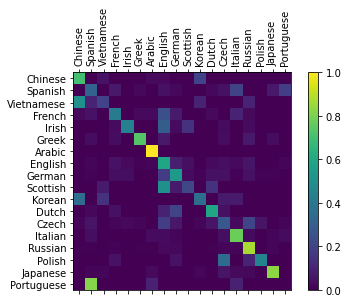

In [ ]:
# evaluate on test set and display confusion matrix
gru = torch.load('char_gru_classification_model.pt')
average_test_loss, confusion = eval_dataset(test_data, gru)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### LSTM Hidden Unit

Average test loss: 0.890730189546193


<ipython-input-22-0d8a37162ef4>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-22-0d8a37162ef4>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


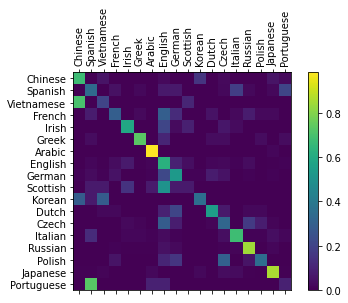

In [ ]:
# evaluate on test set and display confusion matrix
lstm = torch.load('char_lstm_classification_model.pt')
average_test_loss, confusion = eval_dataset(test_data, lstm)
print('Average test loss: ' + str(average_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Explanation:

- GRU and LSTM hidden unit based RNN is performing better than Linear Hidden Unit based RNN. The main reason for this is GRU and LSTM uses multiple gates to decide and store the text information based on context; whereas, linear hidden unit model does not have this capability of deciding based on gates, but it just learns weights based on linear transformation of input and previous hidden unit information. In turn, LSTM and GRU facilitates long term memory, whereas linear hidden unit does not. Also the gate based architecture of GRU and LSTM solves the vanishing gradient problem of linear hidden unit based RNN.
- Apart from that, LSTM model uses 3 gates and has comparatively more complex architecture than 2 gates based GRU model. This justifies why LSTM is performing slightly better than GRU in our case. But, due to simlicity and equivalent level of performance, we can still use GRU especially for small scale NLP problems; and LSTM would be preferred for larger scale NLP problems.

Running on User Input
---------------------




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), rnn) # using linear hidden unit based RNN model

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.55) Russian
(-1.01) Czech
(-3.27) English

> Jackson
(-1.26) English
(-1.80) Czech
(-1.83) Russian

> Satoshi
(-0.85) Polish
(-1.41) Japanese
(-2.10) Italian


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


